In [38]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from model_reg import *

import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
OUTPUT_PATH50c = '../output/PIT2015_02_attention_50d_cls.output'
OUTPUT_PATH200c = '../output/PIT2015_03_attention_200d_cls.output'
OUTPUT_PATH50r = '../output/PIT2015_04_attention_50d_reg.output'
OUTPUT_PATH200r = '../output/PIT2015_05_attention_200d_reg.output'

In [43]:
HISTORY = '50d_reg.his'
f=open(HISTORY, 'rb')
loss_his=pickle.load(f)
acc_his=pickle.load(f)
f.close()

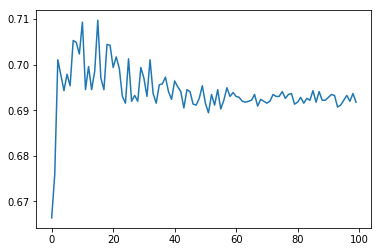

In [44]:
plt.plot(acc_his)
plt.show()

In [45]:
def run_model(data_path, output_path, model, reg=False):
    with open(data_path, 'rb') as f:
        x0 = pickle.load(f)
        x1 = pickle.load(f)

    model = model.to(device)
    x0 = x0.to(device)
    x1 = x1.to(device)
    y_pred = model(x0, x1)
    if not reg:
        y_pred = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
    print(y_pred.size())
    
    with open(output_path, 'w') as f:
        for y in y_pred:
            if not reg:
                if y>=3:
                    f.write('true\t')
                else:
                    f.write('false\t')
                f.write(str(float(y.item())/5) + '\n')
            else:
                if y>=0.5:
                    f.write('true\t')
                else:
                    f.write('false\t')
                f.write(str(y.item()) + '\n')

In [46]:
def make_model(d_model, max_len, N=6, d_ff=256, h=5, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = AttentionEnc(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        c(position), d_model, max_len)
        
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [73]:
d_model=200
MODEL_PATH = 'models/reg_attention_200d_epoch_23.torch'
DATA_PATH = '../data/test_data_'+str(d_model)+'d.pkl'
model = make_model(d_model, 18)
model.load_state_dict(torch.load(MODEL_PATH))
run_model(DATA_PATH, OUTPUT_PATH200r, model, reg=True)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


torch.Size([972, 1])
